Using Colab cache for faster access to the 'vehide-dataset-automatic-vehicle-damage-detection' dataset.
Path to dataset files: /kaggle/input/vehide-dataset-automatic-vehicle-damage-detection
Found 13945 images
Sample files: ['/kaggle/input/vehide-dataset-automatic-vehicle-damage-detection/validation/validation/30012020_090040image398293.jpg', '/kaggle/input/vehide-dataset-automatic-vehicle-damage-detection/validation/validation/a6f9c7a2e9fd11a348ec.jpg', '/kaggle/input/vehide-dataset-automatic-vehicle-damage-detection/validation/validation/06012020_084712image913220.jpg', '/kaggle/input/vehide-dataset-automatic-vehicle-damage-detection/validation/validation/03012020_104157image961259.jpg', '/kaggle/input/vehide-dataset-automatic-vehicle-damage-detection/validation/validation/Thumbnailb75f36416e0a9654cf1b_(1).jpg']
Loaded 5 images
Output layers: ['yolo_82', 'yolo_94', 'yolo_106']


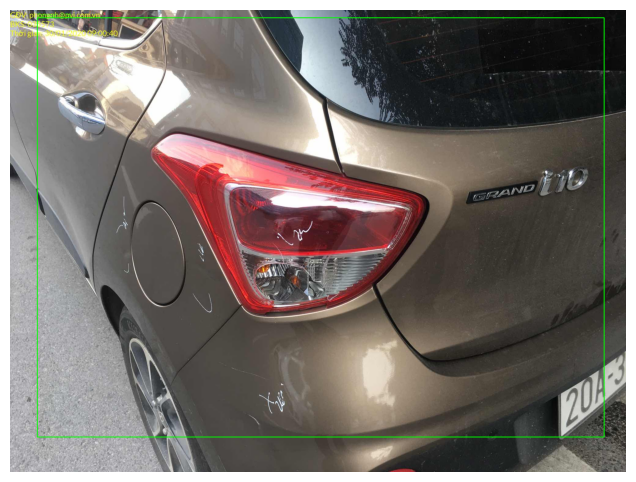

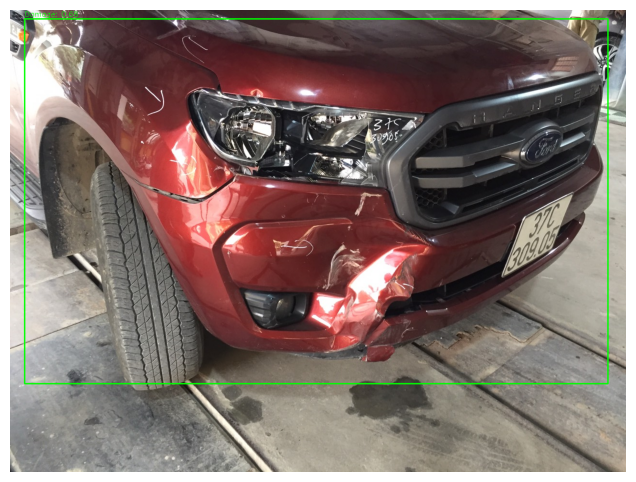

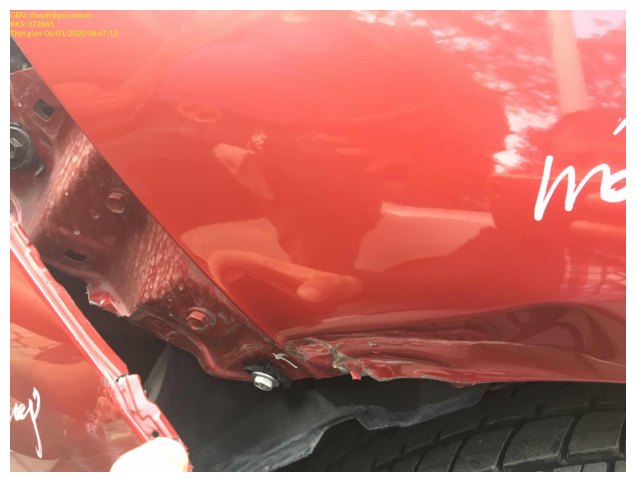

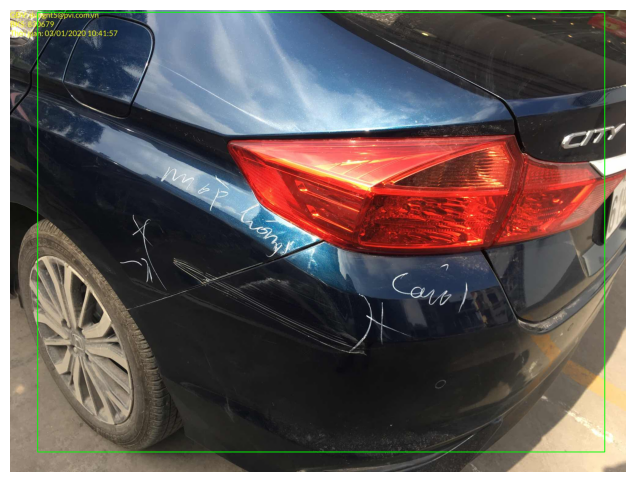

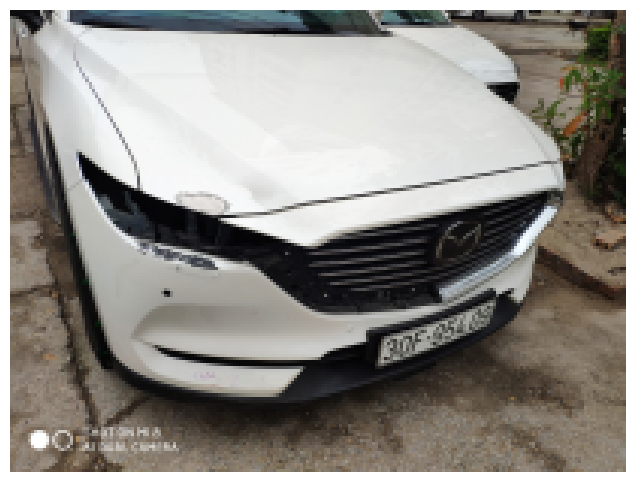

In [14]:
# Step 0: Install dependencies
!pip install opencv-python-headless matplotlib kagglehub

# Step 1: Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import kagglehub

# Step 2: Download latest vehicle damage dataset
path = kagglehub.dataset_download("hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection")
print("Path to dataset files:", path)

# Step 3: Inspect dataset and collect image paths
image_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(('.jpg', '.png')):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} images")
print("Sample files:", image_files[:5])

# Load first 5 images for demo
images = [cv2.imread(f) for f in image_files[:5] if cv2.imread(f) is not None]
print(f"Loaded {len(images)} images")

# Step 4: Load YOLOv3 network
yolo_cfg = "darknet/cfg/yolov3.cfg"   # Path to YOLOv3 cfg
yolo_weights = "yolov3.weights"       # Path to pretrained weights

# Download YOLOv3 weights if not present
if not os.path.exists(yolo_weights):
    !wget https://pjreddie.com/media/files/yolov3.weights

net = cv2.dnn.readNetFromDarknet(yolo_cfg, yolo_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Version-safe way to get output layers
layer_names = net.getLayerNames()
unconnected_out_layers = net.getUnconnectedOutLayers()
if len(unconnected_out_layers.shape) > 1:
    output_layers = [layer_names[i[0] - 1] for i in unconnected_out_layers]
else:
    output_layers = [layer_names[i - 1] for i in unconnected_out_layers]

print("Output layers:", output_layers)

# Step 5: Run YOLOv3 inference and plot results
conf_threshold = 0.5
nms_threshold = 0.4

for img in images:
    height, width = img.shape[:2]

    # Create blob and forward pass
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    # Parse detections
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Max Suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # Draw bounding boxes
    # Handle different OpenCV versions for NMS output
    if len(indices) > 0:
      if isinstance(indices, tuple):
          indices = indices[0]  # unpack if it's a tuple
      for i in indices.flatten():
          x, y, w, h = boxes[i]
          cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
          text = f"Damage: {confidences[i]:.2f}"
          cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)


    # Plot image with bounding boxes
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
